<a href="https://colab.research.google.com/github/cgyireh1/Time-Series-Forecasting_Formative/blob/main/notebook/Air_Quality_Forecasting_Best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [237]:
# import necessary libraries
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [238]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [240]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [241]:
# Inspecting the last few rows of the dataset to understand its structure.
train.tail()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
30671,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,2013-07-01 23:00:00,-0.690542,-0.732019,-0.522096,50.0
30672,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,2013-07-02 00:00:00,1.448138,-0.732019,-0.522096,41.0
30673,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,2013-07-02 01:00:00,1.448138,-0.732019,-0.522096,32.0
30674,30675,1.190496,0.701029,-2.088668,-0.146953,-0.069353,4.806358,2013-07-02 02:00:00,1.448138,-0.732019,-0.522096,19.0
30675,30676,1.190496,0.701029,-2.186052,-0.084366,-0.069353,-0.137667,2013-07-02 03:00:00,1.448138,-0.732019,-0.522096,18.0


In [242]:
# Checking the columns
train.columns
print("Train columns:", train.columns)
print("Test columns:", test.columns)

Train columns: Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')
Test columns: Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv'],
      dtype='object')


In [243]:
# shape of training data
print(train.shape)

(30676, 12)


In [244]:
# shape of testing data
print(test.shape)

(13148, 11)


## Checking Missing Values in the Dataset

In [245]:
# Checking missing values in the Training Dataset
print('Checking Missing Values in the Training Dataset')
missing_values = train.isnull().sum()
print(missing_values)

Checking Missing Values in the Training Dataset
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [246]:
# Checking missing values in the Testing Dataset
print('Checking Missing Values in the Testing Dataset')
missing_values = test.isnull().sum()
print(missing_values)

Checking Missing Values in the Testing Dataset
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


In [247]:
# missing values as a percentage of the total rows
missing_percentage = (train.isnull().sum() / len(train))*100
print(f'missing values as percentage of the total: {missing_percentage[missing_percentage > 0]}')

missing values as percentage of the total: pm2.5    6.262225
dtype: float64


In [248]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [249]:
# filling mission values with the mean
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [250]:
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427


In [251]:
# Checking missing values in the Training Dataset
print('Checking Missing Values Filling')
missing_values = train.isnull().sum()
print(missing_values)

Checking Missing Values Filling
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64


## Exploratory Data Analysis(EDA)

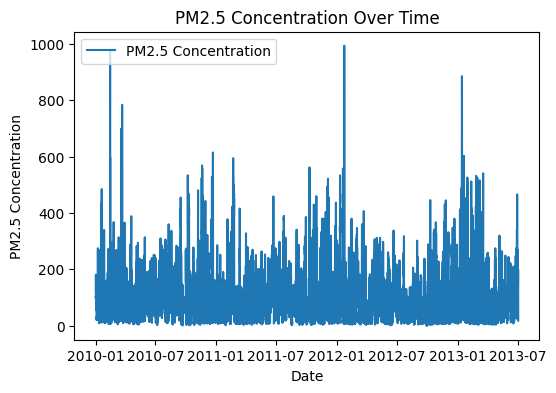

In [252]:
# line plot of pm2.5 over time
plt.figure(figsize=(6, 4))
plt.plot(train.index, train['pm2.5'], label='PM2.5 Concentration')
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

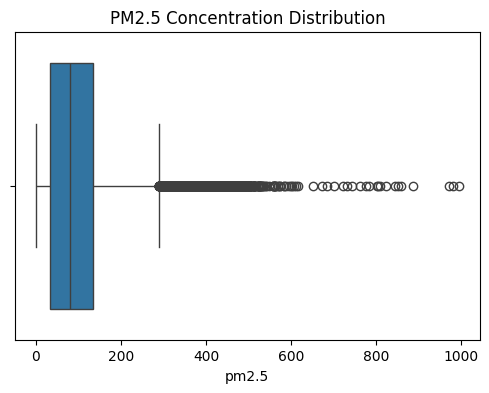

In [253]:
# Box plot of PM2.5 Concentration Distribution
plt.figure(figsize=(6, 4))
sns.boxplot(x=train['pm2.5'])
plt.title('PM2.5 Concentration Distribution')
plt.show()


## Finding and handling **Outliers**

In [254]:
Q1 = train['pm2.5'].quantile(0.25)
Q3 = train['pm2.5'].quantile(0.75)
IQR = Q3 - Q1

# Defining uotlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying outliers
outliers = train[(train['pm2.5'] < lower_bound) | (train['pm2.5'] > upper_bound)]
print(f"Initial Outliers detected: {outliers.shape[0]} rows")

Initial Outliers detected: 1335 rows


In [255]:
# Handling the outliers using the clipping method
train['pm2.5'] = train['pm2.5'].clip(lower=lower_bound, upper=upper_bound)

In [256]:
# outliers after handling
outliers = train[(train['pm2.5'] < lower_bound) | (train['pm2.5'] > upper_bound)]
print(f"Outliers detected After Handling: {outliers.shape[0]} rows")


Outliers detected After Handling: 0 rows


### Histograms

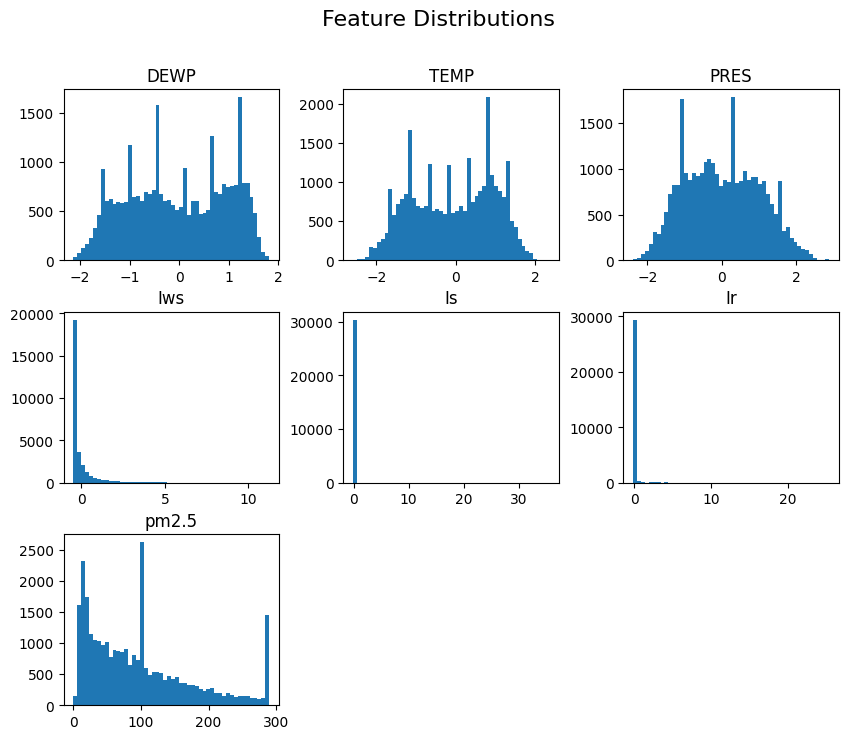

In [257]:
# Plotting the histograms
train[['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']].hist(bins=50, figsize=(10, 8), grid=False)
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()


### Heatmap

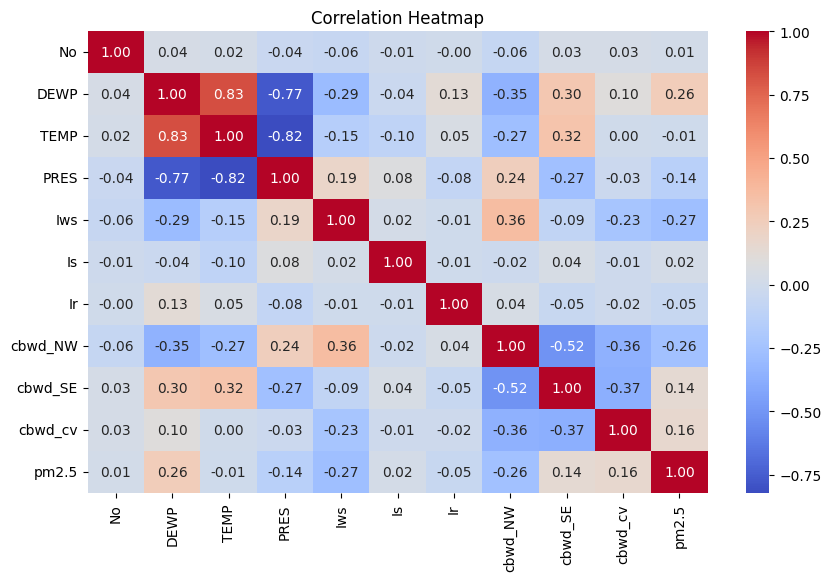

In [165]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [166]:
# creating additional datetime-based features
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['weekday'] = train.index.weekday
test['hour'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['weekday'] = test.index.weekday

In [167]:
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,day,month,weekday
datetime,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,0,1,1,4
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,1,1,4
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,2,1,1,4
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,3,1,1,4
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,4,1,1,4


In [168]:
train.shape

(30676, 15)

In [169]:
test.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,hour,day,month,weekday
datetime,,,,,,,,,,,,,,
2013-07-02 04:00:00,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,4,2,7,1
2013-07-02 05:00:00,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,5,2,7,1
2013-07-02 06:00:00,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,6,2,7,1
2013-07-02 07:00:00,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,7,2,7,1
2013-07-02 08:00:00,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,8,2,7,1


In [170]:
test.shape

(13148, 14)

In [171]:
# Separate features and target
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']
X_test = test.drop(['No'], axis=1)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)  # (samples, timesteps, features)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, shuffle=False)

In [172]:
X_train_scaled.shape

(30676, 1, 13)

In [173]:
X_test_scaled.shape

(13148, 1, 13)

In [174]:
X_train_split.shape

(24540, 1, 13)

In [175]:
X_val_split.shape

(6136, 1, 13)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.


In [176]:
# define the model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='relu', kernel_regularizer=l2(0.001)), input_shape=(X_train_split.shape[1], X_train_split.shape[2])),
    LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=l2(0.001)),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         145,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 64)               │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,033 (937.63 KB)

 Trainable params: 240,033 (937.63 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [177]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# start time for the model training
start_time = time.time()

# Train the model
start_time = time.time()
history = model.fit(
    X_train_split, y_train_split,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 9163.6719 - val_loss: 5084.6816 - learning_rate: 5.0000e-04
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 4084.5039 - val_loss: 4352.8047 - learning_rate: 5.0000e-04
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 3749.7676 - val_loss: 4006.9941 - learning_rate: 5.0000e-04
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 3624.4441 - val_loss: 3715.7473 - learning_rate: 5.0000e-04
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 3420.7397 - val_loss: 3442.4351 - learning_rate: 5.0000e-04
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 3205.0952 - val_loss: 3240.1650 - learning_rate: 5.0000e-04
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 3052.7688 - val_loss: 3290.5486 - learning_rate: 5.0000e-04
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 3011.8926 - val_loss: 3151.5137 - learning_rate: 5.0000e-04
Epoch 9/20
767/767 ━━━━━━━

In [178]:
# Calculate training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 185.18 seconds


767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


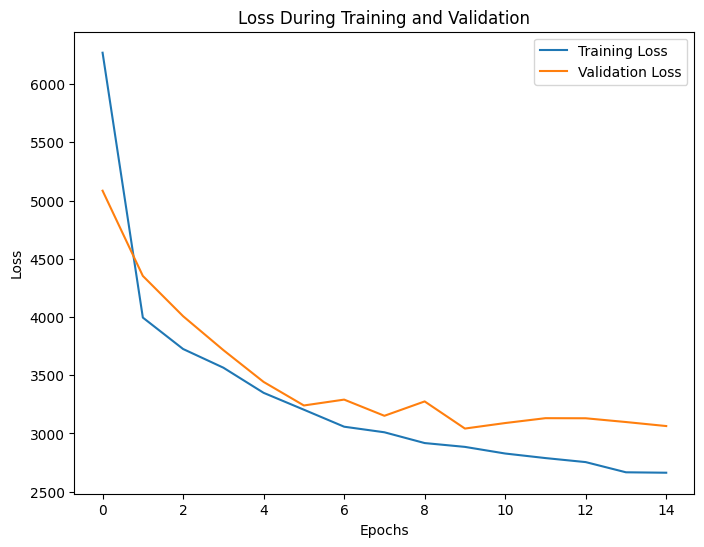

In [179]:
# Evaluate model on training and validation set
train_predictions = model.predict(X_train_split)
val_predictions = model.predict(X_val_split)

# Visualize the training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [180]:
#Loss and RMSE
train_loss = mean_squared_error(y_train_split, train_predictions)
val_loss = mean_squared_error(y_val_split, val_predictions)
RMSE = np.sqrt(train_loss)

print(f'Training Loss (MSE): {train_loss:.4f}')
print(f'Validation Loss (MSE): {val_loss:.4f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.4f}')

Training Loss (MSE): 2509.9890
Validation Loss (MSE): 3040.4795
Root Mean Squared Error (RMSE): 50.0998


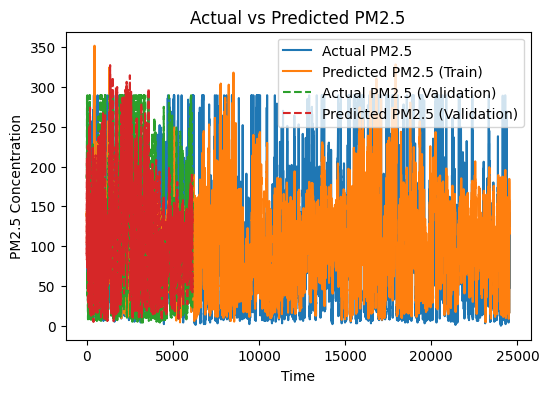

In [236]:
# Visualize predictions vs actual values
plt.figure(figsize=(6, 4))
plt.plot(y_train_split.values, label='Actual PM2.5')
plt.plot(train_predictions.flatten(), label='Predicted PM2.5 (Train)')
plt.plot(y_val_split.values, label='Actual PM2.5 (Validation)', linestyle='--')
plt.plot(val_predictions.flatten(), label='Predicted PM2.5 (Validation)', linestyle='--')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

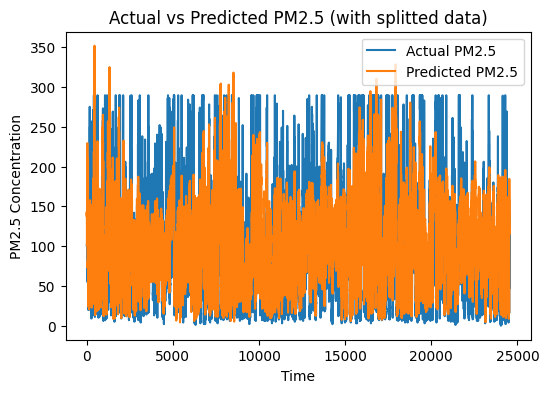

In [235]:
# Visualize predictions vs actual values(with splitted values)
plt.figure(figsize=(6, 4))
plt.plot(y_train_split.values, label='Actual PM2.5')
plt.plot(train_predictions.flatten(), label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (with splitted data)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

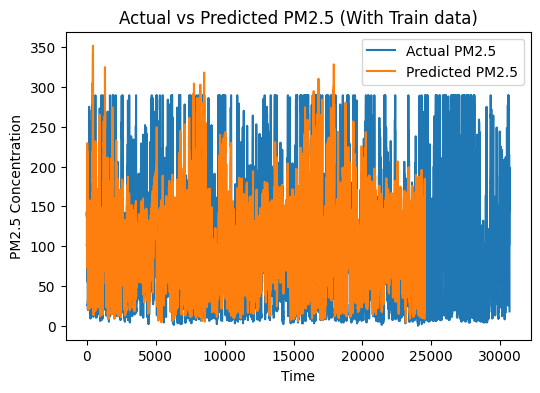

In [229]:
# Visualize predictions vs actual values(With Train data)
plt.figure(figsize=(6, 4))
plt.plot(y_train.values, label='Actual PM2.5')
plt.plot(train_predictions.flatten(), label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (With Train data)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

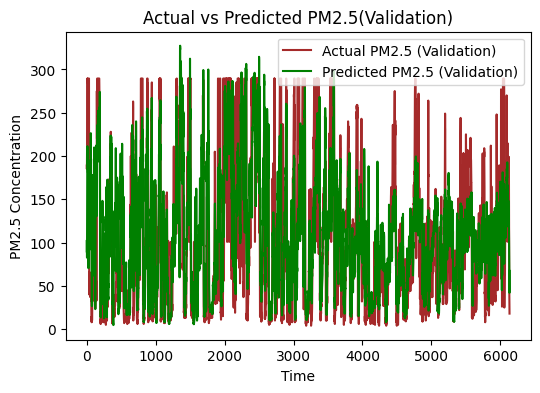

In [230]:
# Visualize predictions vs actual values
plt.figure(figsize=(6, 4))
plt.plot(y_val_split.values, color='brown', label='Actual PM2.5 (Validation)')
plt.plot(val_predictions.flatten(), color='green', label='Predicted PM2.5 (Validation)')
plt.title('Actual vs Predicted PM2.5(Validation)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

In [258]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/subm_fixed_17.csv', index=False)


411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
